In [1]:
# basic
import numpy as np
import pandas as pd 
import datetime as dt 

# Main Datasource
from pandas_datareader import data as pdr 

# Plot Figure
import matplotlib.pyplot as plt 
import matplotlib.dates as mdates 

In [2]:
class Company_Data():
    """
    ticker     --> list (str)
    start ,end --> datetime 
    peirods    --> string
    """
    def __init__(self,tickers,start,end,periods):

        self.start   = start 
        self.end     = end 
        self.tickers = tickers
        self.periods = periods
    
    def get_data(self,ticker):

        self.df = pdr.get_data_yahoo(ticker,self.start,self.end).reset_index()
   
        return self.df 
    
    def Address_date(self,date):
        date = str(date)[:10]
        return date
    
    def get_price_data(self):

        for i , ticker in enumerate(self.tickers) : 
            
            if i == 0 :
                Price_DF = self.get_data(ticker)
                Price_DF = Price_DF[['Date','Close']]
                Price_DF.columns = ['Date',str(ticker)]
            else:
                Merge_DF = self.get_data(ticker)[['Date','Close']]
                Merge_DF.columns = ['Date',str(ticker)]
                Price_DF = Price_DF.merge(Merge_DF,how='outer')
        
        Price_DF = Price_DF.fillna(value=0)
        Price_DF['Date'] = Price_DF.apply(lambda x : self.Address_date(x['Date']),axis=1)
        Price_DF.index   = Price_DF['Date']
        Price_DF         = Price_DF.drop(['Date'],axis=1)

        return Price_DF

# ------------ Company_DF parameters ------------ 

start   = dt.datetime(2019,1,1)
end     = dt.datetime(2020,12,31)
tickers = ['AAPL',"MSFT","SHOP","INTC","TSLA","JPM","MS","GS","BAC","UBS",'SPY'] # 10 Stocks + Markets

# ------------ ------------ ------------ ------------ 

Company_Price = Company_Data(tickers=tickers,start=start,end=end,periods="Daily")
Stock_DF      = Company_Price.get_price_data()
Stock_DF 

,AAPL,MSFT,SHOP,INTC,TSLA,JPM,MS,GS,BAC,UBS,SPY
Date,,,,,,,,,,,
2018-12-31,39.435001,101.570000,138.449997,46.930000,66.559998,97.620003,39.650002,167.050003,24.639999,12.38,249.919998
2019-01-02,39.480000,101.120003,137.600006,47.080002,62.023998,99.309998,40.400002,172.029999,24.959999,12.55,250.179993
2019-01-03,35.547501,97.400002,129.789993,44.490002,60.071999,97.110001,39.680000,169.509995,24.559999,12.39,244.210007
2019-01-04,37.064999,101.930000,138.059998,47.220001,63.537998,100.690002,41.299999,175.050003,25.580000,12.84,252.389999
2019-01-07,36.982498,102.059998,144.389999,47.439999,66.991997,100.760002,41.709999,176.020004,25.559999,12.97,254.380005
...,...,...,...,...,...,...,...,...,...,...,...
2020-12-24,131.970001,222.750000,1225.520020,47.070000,661.770020,124.519997,68.089996,256.160004,29.959999,14.07,369.000000
2020-12-28,136.690002,224.960007,1147.060059,47.070000,663.690002,125.339996,68.050003,259.589996,30.129999,14.08,372.170013
2020-12-29,134.869995,224.149994,1171.609985,49.389999,665.989990,125.010002,67.709999,258.010010,30.010000,14.11,371.459991


In [3]:
class MyFactor():


    def __init__(self,Stock_Data):

        self.Stock_Data = Stock_Data 

    def DataFrame(self,Method):

        # tickers & store_list 
        tickers = []
        Factors = []
        cols = self.Stock_Data.columns

        # factor 
        if Method == "Momentum" :

            Method = self.Momentum

        
        # start calculate
        for i in range(len(cols)):
            
            # data & calcluation
            price  = self.Stock_Data[str(cols[i])].to_list()
            Factor = Method(price)

            # store value
            tickers.append(cols[i])
            Factors.append(Factor)

        # output factor dataframe
        Factor_DF = pd.DataFrame()
        Factor_DF['Tickers']                      = tickers
        Factor_DF[str(Method.__name__)+" Factor"] = Factors
        Factor_DF = Factor_DF.sort_values(by=str(Method.__name__)+" Factor",ascending=False).reset_index(drop=True)
        
        Factor_DF.index = Factor_DF['Tickers']
        Factor_DF       = Factor_DF.drop(['Tickers'],axis=1)

        return Factor_DF


    def Momentum(self,prices):


        Change_in_Over_the_year  = (prices[-21] - prices[-252]) / prices[-252]
        Change_in_Over_the_month = (prices[-1] - prices[-21]) / prices[-21] 

        # handle returns inf value problem
        returns  = pd.Series(prices).pct_change()
        returns.replace([np.inf, -np.inf], np.nan, inplace=True)
        returns = returns.dropna()

        # price change in over time / standarized 
        Momentum_Factor  = ( Change_in_Over_the_year - Change_in_Over_the_month ) / np.nanstd(returns, axis=0)

        return Momentum_Factor 
        

In [4]:
Stock_DF_Rolling = Stock_DF.rolling(window=252)
a = 0

for rolling_df in Stock_DF_Rolling :


    if rolling_df.shape[0] >= 252 : 

        date      = str(rolling_df.index[0])[:10]
        Factor    = MyFactor(Stock_Data = rolling_df )
        Factor_DF = Factor.DataFrame(Method="Momentum")

        if a == 0 : 

            Rolling_Factor_Score = Factor_DF
            Column_Name = [date + " Momentum"]
            Rolling_Factor_Score.columns = Column_Name 
            a+=1
            
        else:

            Column_Name = [date + " Momentum"]
            Factor_DF.columns = Column_Name
            Rolling_Factor_Score = pd.concat([Rolling_Factor_Score,Factor_DF],axis=1)
            

Rolling_Factor_Score

,2018-12-31 Momentum,2019-01-02 Momentum,2019-01-03 Momentum,2019-01-04 Momentum,2019-01-07 Momentum,2019-01-08 Momentum,2019-01-09 Momentum,2019-01-10 Momentum,2019-01-11 Momentum,2019-01-14 Momentum,...,2019-12-19 Momentum,2019-12-20 Momentum,2019-12-23 Momentum,2019-12-24 Momentum,2019-12-26 Momentum,2019-12-27 Momentum,2019-12-30 Momentum,2019-12-31 Momentum,2020-01-02 Momentum,2020-01-03 Momentum
Tickers,,,,,,,,,,,,,,,,,,,,,
SHOP,46.059306,44.141189,56.992962,60.088258,51.827752,51.404610,50.976282,49.226627,50.473784,49.130755,...,26.401170,30.337390,31.810443,27.435058,27.116750,30.763971,35.459330,39.399511,36.234523,38.272288
AAPL,36.594514,34.023002,43.816498,41.833538,44.321240,46.203087,40.326364,39.356728,42.041945,42.719033,...,20.330380,21.509925,19.099641,15.111420,15.401378,15.816519,14.526979,16.605490,18.517990,19.622963
MSFT,35.862161,33.888270,37.087276,34.194063,33.923229,36.321351,32.666864,32.010260,34.177488,36.156085,...,11.427070,11.585513,10.065680,9.727142,11.352201,10.974228,11.576325,11.207580,11.587938,11.747199
SPY,29.865544,26.924896,28.083498,26.481040,25.246503,26.895500,24.452020,22.586732,23.763369,26.414312,...,3.096243,3.955665,3.353506,4.038976,5.331528,5.002158,5.166307,4.677499,5.219057,5.597057
JPM,25.077303,22.280684,21.211676,23.163885,24.257404,28.839592,27.403224,27.230023,28.135755,31.945676,...,-5.827257,-5.510530,-7.098800,-5.118177,-3.706905,-4.176426,-4.648098,-6.258740,-5.776405,-4.635444
BAC,20.414523,19.645701,17.346347,16.923884,16.802862,20.289947,17.897675,17.977137,18.066416,21.179452,...,-8.045372,-7.890162,-9.392814,-7.813094,-5.974195,-5.697975,-5.799432,-7.193327,-6.487043,-5.688948
GS,19.266938,14.116950,10.010698,10.979427,10.634797,15.818659,12.591734,11.349574,10.554725,12.210222,...,-3.498826,-2.976821,-5.340225,-2.963682,-1.594997,-1.742703,-2.377242,-3.521431,-3.868042,-2.531327
MS,14.830251,11.822292,8.927181,9.276255,9.452545,12.378056,10.267564,9.954825,8.901325,10.517126,...,1.573465,1.720701,-0.926850,2.300710,4.744375,4.689156,5.155966,3.157596,3.973910,4.970238
INTC,12.317920,10.958537,10.495006,6.973760,6.970091,9.357731,8.233116,7.206416,8.195029,9.502210,...,-10.425294,-7.961898,-7.613923,-6.779833,-6.113322,-6.485903,-5.854136,-6.350240,-5.025825,-4.994605


In [5]:
cols             = Rolling_Factor_Score.columns
Rebalanced_Dates = 30
Date_Count       = 0

Date_list = []
Long_Equityies_list = []
Short_Equities_list = []

for i in range(Rolling_Factor_Score.shape[1]):

    # Parameters
    col  = str(cols[i])
    date = str(cols[i])[:10]
    Date_Count +=1
    if Date_Count == Rebalanced_Dates :

        Score_Factor = Rolling_Factor_Score[col]
        Score_Factor = Score_Factor.reset_index()
        sort_cols = Score_Factor.columns[-1]
        Score_Factor = Score_Factor.sort_values(by=sort_cols,ascending=False)
    

        Equities_List  = Score_Factor['Tickers'].to_list()
        Buy_Equities   = Equities_List[ :int(len(Equities_List)*0.25) ]
        Short_Equities =   Equities_List[int(1-len(Equities_List)*0.25) : ]

        Date_list.append(date)
        Long_Equityies_list.append(Buy_Equities)
        Short_Equities_list.append(Short_Equities)

        Date_Count = 0

Strategy_Signal = pd.DataFrame()
Strategy_Signal['Date']  = Date_list
Strategy_Signal['Long']  = Long_Equityies_list
Strategy_Signal['Short'] = Short_Equities_list
Strategy_Signal 

,Date,Long,Short
0,2019-02-12,"[AAPL, SHOP]",[UBS]
1,2019-03-27,"[TSLA, SHOP]",[UBS]
2,2019-05-09,"[TSLA, INTC]",[UBS]
3,2019-06-21,"[TSLA, SHOP]",[BAC]
4,2019-08-05,"[TSLA, SHOP]",[BAC]
5,2019-09-17,"[TSLA, SHOP]",[JPM]
6,2019-10-29,"[TSLA, SHOP]",[JPM]
7,2019-12-11,"[TSLA, SHOP]",[INTC]


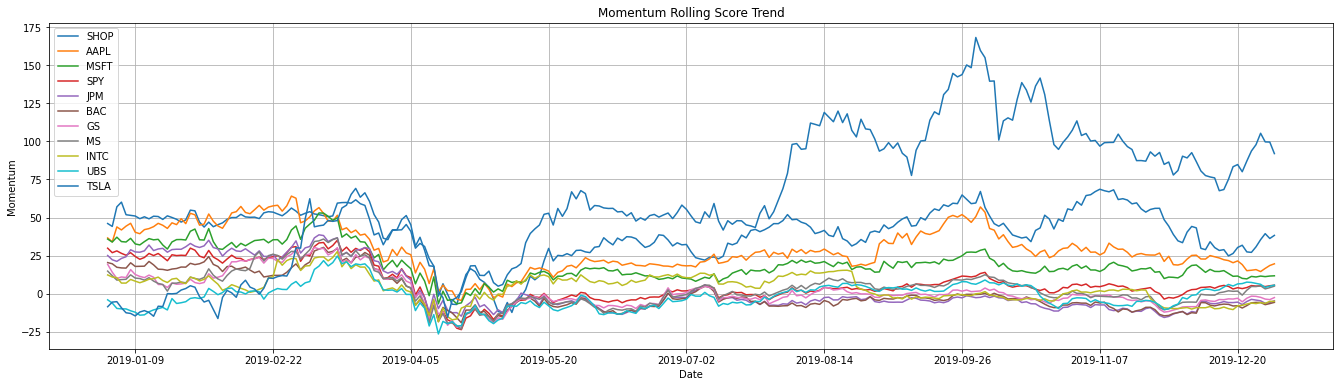

In [6]:
x = [ str(x)[:10] for x in Rolling_Factor_Score.columns]

fig,ax = plt.subplots(figsize=(23,6))
ax.set_title('Momentum Rolling Score Trend')

for i in range(Rolling_Factor_Score.shape[0]):
    ax.plot(x,Rolling_Factor_Score.iloc[i],label=str(Rolling_Factor_Score.index.to_list()[i]))

plt.gca().xaxis.set_major_locator(mdates.DayLocator(interval=30))
plt.ylabel('Momentum')
plt.xlabel('Date')
plt.legend()
plt.grid()
plt.show()

In [7]:
Stock_Return_DF = Stock_DF.pct_change().dropna()
Portfolio_Return = []


for i in range(Strategy_Signal.shape[0]):
    
    if i == Strategy_Signal.shape[0]-1 :
        break

    else:

        # ---------- Trading Signal ----------
        start_date  = Strategy_Signal['Date'][i]
        end_date    = Strategy_Signal['Date'][i+1]
        long_stock  = Strategy_Signal['Long'][i]
        short_stock = Strategy_Signal['Short'][i]
        
        index_list = Stock_Return_DF.index.to_list()
        start_index = index_list.index(str(start_date))
        end_index   = index_list.index(str(end_date))
        # ------------------------------------

        period_long_portfolio  = Stock_Return_DF[start_index:end_index][long_stock]
        period_short_portfolio = Stock_Return_DF[start_index:end_index][short_stock] * -1 
        period_portfolio       = pd.concat([period_long_portfolio,period_short_portfolio],axis=1)

        # ------------------------------------

        if i == 0 : 
            
            Back_Testing_Portfolio = period_portfolio
        
        else :

            Back_Testing_Portfolio = pd.concat([Back_Testing_Portfolio,period_portfolio ])


Back_Testing_Portfolio = Back_Testing_Portfolio.fillna(value=0)

# Construct Portfolio Return
Portfolio_Return_List = []
for i in range(Back_Testing_Portfolio.shape[0]):
    Portfolio_Return = Back_Testing_Portfolio.iloc[i].sum()
    Portfolio_Return_List.append(Portfolio_Return)

Back_Testing_Portfolio['Portfolio Return'] = Portfolio_Return_List
Back_Testing_Portfolio['Portfolio Cumsum Return'] = np.cumsum(Portfolio_Return_List)
Back_Testing_Portfolio = Back_Testing_Portfolio.merge(Stock_Return_DF['SPY'],left_index=True,right_index=True) # Merge with Market Return
Back_Testing_Portfolio

,AAPL,SHOP,UBS,TSLA,INTC,BAC,JPM,Portfolio Return,Portfolio Cumsum Return,SPY
Date,,,,,,,,,,
2019-02-12,0.008617,0.013744,-0.010244,0.000000,0.0,0.0,0.000000,0.012117,0.012117,0.012859
2019-02-13,-0.004155,-0.020108,-0.007020,0.000000,0.0,0.0,0.000000,-0.031283,-0.019167,0.003247
2019-02-14,0.003643,0.026160,0.017816,0.000000,0.0,0.0,0.000000,0.047619,0.028452,-0.002218
2019-02-15,-0.002225,0.009461,-0.021293,0.000000,0.0,0.0,0.000000,-0.014058,0.014394,0.010897
2019-02-19,0.002993,0.017453,0.002317,0.000000,0.0,0.0,0.000000,0.022762,0.037157,0.001731
...,...,...,...,...,...,...,...,...,...,...
2019-12-04,0.000000,0.060857,0.000000,-0.009429,0.0,0.0,-0.019726,0.031702,0.863137,0.006170
2019-12-05,0.000000,-0.022608,0.000000,-0.007987,0.0,0.0,-0.005441,-0.036035,0.827102,0.001798
2019-12-06,0.000000,0.002778,0.000000,0.016709,0.0,0.0,-0.014880,0.004606,0.831708,0.009134


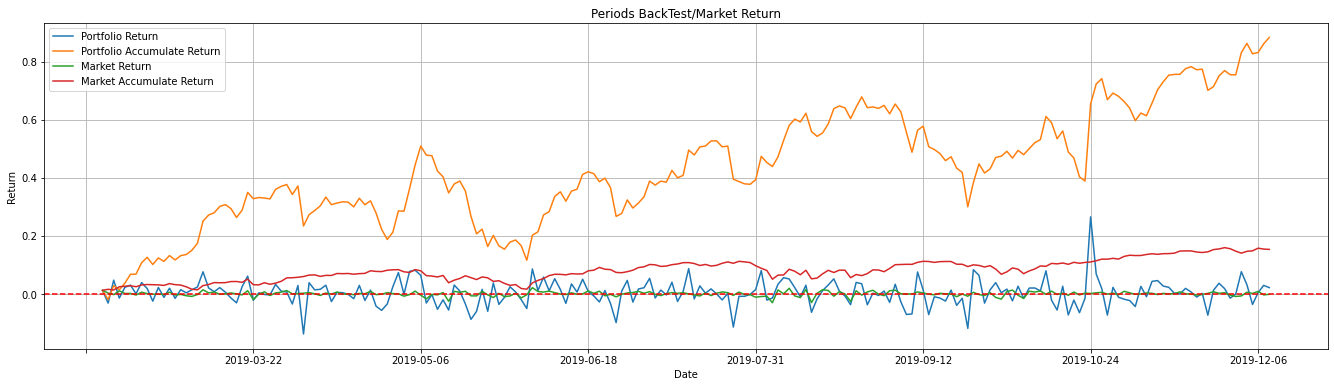

In [8]:
fig,ax = plt.subplots(figsize=(23,6))
ax.set_title('Periods BackTest/Market Return')

#  Portfolio Strategy Return
ax.plot(Back_Testing_Portfolio.index , Back_Testing_Portfolio['Portfolio Return'],label='Portfolio Return')
ax.plot(Back_Testing_Portfolio.index , Back_Testing_Portfolio['Portfolio Cumsum Return'],label='Portfolio Accumulate Return')

#  Market Return
ax.plot(Back_Testing_Portfolio.index , Back_Testing_Portfolio['SPY'],label='Market Return')
ax.plot(Back_Testing_Portfolio.index , Back_Testing_Portfolio['SPY'].cumsum() ,label='Market Accumulate Return')

plt.gca().xaxis.set_major_locator(mdates.DayLocator(interval=30))
plt.axhline(0,color='r',linestyle='--')
plt.ylabel('Return')
plt.xlabel('Date')
plt.legend()
plt.grid()